In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
import category_encoders as ce
from sklearn.metrics import roc_auc_score

np.random.seed(0)


## Data preprocessing & Pipeline

In [3]:
df_train = pd.read_csv('../data/processed/train.csv')
df_val = pd.read_csv('../data/processed/val.csv')

df_train.head(3)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute,Date,Day of Week
0,1290,0,2015,1,1,34.82,Swipe Transaction,3639123430068731390,Jacksonville,FL,32222.0,5814,NaN,0,0,1,2015-01-01,Чт
1,583,1,2015,1,1,69.55,Chip Transaction,5370819399151835274,Giddings,TX,78942.0,5411,NaN,0,0,1,2015-01-01,Чт
2,1470,0,2015,1,1,64.40,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,NaN,0,0,3,2015-01-01,Чт


In [4]:
X_train = df_train.drop('Is Fraud?', axis=1)
X_val = df_val.drop('Is Fraud?', axis=1)
y_train = df_train['Is Fraud?']
y_val = df_val['Is Fraud?']


In [5]:
df_train = None
df_val = None

In [6]:
df_test = pd.read_csv('../data/processed/test.csv')
X_test = df_test.drop('Is Fraud?', axis=1)
y_test = df_test['Is Fraud?']


In [7]:
numeric_features = ["Amount"]

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

In [8]:
categorical_features_target = ["User", "Card", "Merchant Name", "Merchant City", "Merchant State", 'MCC', "Zip"]

categorical_transformer_target = Pipeline(
    steps=[
        ("target_encoder", TargetEncoder())
    ]
)


In [9]:
categorical_features_ohe = ['Year', 'Month', 'Day', 'Use Chip', 'Hour', 'Day of Week']

categorical_transformer_ohe = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat_target", categorical_transformer_target, categorical_features_target),
        ("cat_ohe", categorical_transformer_ohe, categorical_features_ohe)
    ]
)

## Logistic Regression Base Result

In [53]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount']),
                                                 ('cat_target',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['User', 'Card',
                                                   'Merchant Name',
                                                   'Merchant City',
                                                   'Merchant State', 'MCC',
                                                   'Zip']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Year', 'Month', 'Day',
                                                   'Use Chip', 'Hour',
                                                   'Day of Week'])])),
                ('classifier', LogisticRegression())])

In [54]:
val_preds = clf.predict(X_val)

print("Logistic Regression Results:")
print(classification_report(y_val, val_preds))
print(confusion_matrix(y_val, val_preds))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1719124
           1       0.00      0.00      0.00      2491

    accuracy                           1.00   1721615
   macro avg       0.50      0.50      0.50   1721615
weighted avg       1.00      1.00      1.00   1721615

[[1719063      61]
 [   2491       0]]


In [55]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
roc_auc_score(y_test, preds_test)
X_test.Fraud = y_test
X_test.Prediction = preds_test
X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()
X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1721851
           1       0.00      0.00      0.00      2087

    accuracy                           1.00   1723938
   macro avg       0.50      0.50      0.50   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1721803      48]
 [   2087       0]]


0.0

## Decision Tree Base Result

In [11]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", dt_classifier)]
)

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount']),
                                                 ('cat_target',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['User', 'Card',
                                                   'Merchant Name',
                                                   'Merchant City',
                                                   'Merchant State', 'MCC',
                                                   'Zip']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Year', 'Month', 'Day',
                                                   'Use Chip', 'Hour',
                                                   'Day of Week'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])

In [58]:
val_preds = clf.predict(X_val)

print("Decision Tree Base Results:")
print(classification_report(y_val, val_preds))
print(confusion_matrix(y_val, val_preds))

Decision Tree Base Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1719124
           1       0.07      0.08      0.08      2491

    accuracy                           1.00   1721615
   macro avg       0.54      0.54      0.54   1721615
weighted avg       1.00      1.00      1.00   1721615

[[1716442    2682]
 [   2285     206]]


In [60]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(roc_auc_score(y_test, preds_test))
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum())
print(X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum())


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1721851
           1       0.03      0.04      0.03      2087

    accuracy                           1.00   1723938
   macro avg       0.51      0.52      0.52   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1719115    2736]
 [   2009      78]]
0.5178926168526847
3422.8
0.020649771596440675


## Random Forest Base Result

In [61]:
rf_classifier = RandomForestClassifier(n_estimators=40, random_state=42)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", rf_classifier)]
)

clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
val_preds = clf.predict(X_val)

print("Random Forest Results:")
print(classification_report(y_val, val_preds))
print(confusion_matrix(y_val, val_preds))

In [ ]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(roc_auc_score(y_test, preds_test))
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum())
print(X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum())


# Undersampling 0.2

In [62]:
# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.2

fraud_samples = int(y_train.sum())
total_samples = int(fraud_samples / desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples})

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

## Logistic Regression

In [63]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount']),
                                                 ('cat_target',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['User', 'Card',
                                                   'Merchant Name',
                                                   'Merchant City',
                                                   'Merchant State', 'MCC',
                                                   'Zip']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Year', 'Month', 'Day',
                                                   'Use Chip', 'Hour',
                                                   'Day of Week'])])),
                ('classifier', LogisticRegression())])

In [64]:
preds_val = clf.predict(X_val)

print("Logistic Regression Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1719124
           1       0.04      0.98      0.08      2491

    accuracy                           0.97   1721615
   macro avg       0.52      0.97      0.53   1721615
weighted avg       1.00      0.97      0.98   1721615

[[1663297   55827]
 [     51    2440]]


In [65]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1721851
           1       0.04      1.00      0.07      2087

    accuracy                           0.97   1723938
   macro avg       0.52      0.98      0.53   1723938
weighted avg       1.00      0.97      0.98   1723938

[[1665679   56172]
 [     10    2077]]
AUC: 0.9812927006578733
FC: 165313.82
FCR: 0.9973392032064702


## DT Under

In [66]:
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", dt_classifier)]
)

clf.fit(X_resampled, y_resampled)

preds_val = clf.predict(X_val)

print("DT Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount']),
                                                 ('cat_target',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['User', 'Card',
                                                   'Merchant Name',
                                                   'Merchant City',
                                                   'Merchant State', 'MCC',
                                                   'Zip']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Year', 'Month', 'Day',
                                                   'Use Chip', 'Hour',
                                                   'Day of Week'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])

In [67]:
preds_val = clf.predict(X_val)

print("DT Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

DT Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1719124
           1       0.03      0.57      0.05      2491

    accuracy                           0.97   1721615
   macro avg       0.51      0.77      0.52   1721615
weighted avg       1.00      0.97      0.98   1721615

[[1664682   54442]
 [   1063    1428]]


In [68]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1721851
           1       0.02      0.56      0.04      2087

    accuracy                           0.97   1723938
   macro avg       0.51      0.77      0.51   1723938
weighted avg       1.00      0.97      0.98   1723938

[[1666245   55606]
 [    911    1176]]
AUC: 0.7655969724174189
FC: 68609.28
FCR: 0.4139201710284694


## RF Undersampling

In [69]:
rf_classifier = RandomForestClassifier(n_estimators=40, random_state=42)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", rf_classifier)]
)

clf.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount']),
                                                 ('cat_target',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['User', 'Card',
                                                   'Merchant Name',
                                                   'Merchant City',
                                                   'Merchant State', 'MCC',
                                                   'Zip']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Year', 'Month', 'Day',
                                                   'Use Chip', 'Hour',
                                                   'Day of Week'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=40, random_state=42))])

In [71]:
preds_val = clf.predict(X_val)

print("RF Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

RF Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1719124
           1       0.08      0.57      0.14      2491

    accuracy                           0.99   1721615
   macro avg       0.54      0.78      0.57   1721615
weighted avg       1.00      0.99      0.99   1721615

[[1702942   16182]
 [   1077    1414]]


In [72]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1721851
           1       0.05      0.45      0.10      2087

    accuracy                           0.99   1723938
   macro avg       0.53      0.72      0.55   1723938
weighted avg       1.00      0.99      0.99   1723938

[[1705213   16638]
 [   1144     943]]
AUC: 0.7210909481137584
FC: 82475.14
FCR: 0.49757298217379575


# Oversampling

In [12]:
from imblearn.over_sampling import RandomOverSampler

In [13]:
desired_proportion = 0.2

fraud_samples = int(y_train.sum())
total_samples = int(fraud_samples / desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
ros =  RandomOverSampler(random_state=42)

# Apply random undersampling to the original dataset
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [14]:
X_resampled.shape

(10253080, 17)

## LR 

In [77]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount']),
                                                 ('cat_target',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['User', 'Card',
                                                   'Merchant Name',
                                                   'Merchant City',
                                                   'Merchant State', 'MCC',
                                                   'Zip']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Year', 'Month', 'Day',
                                                   'Use Chip', 'Hour',
                                                   'Day of Week'])])),
                ('classifier', LogisticRegression())])

In [78]:
preds_val = clf.predict(X_val)

print("Logistic Regression Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1719124
           1       0.03      0.99      0.06      2491

    accuracy                           0.95   1721615
   macro avg       0.51      0.97      0.52   1721615
weighted avg       1.00      0.95      0.97   1721615

[[1639106   80018]
 [     25    2466]]


In [79]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1721851
           1       0.03      1.00      0.05      2087

    accuracy                           0.95   1723938
   macro avg       0.51      0.98      0.51   1723938
weighted avg       1.00      0.95      0.97   1723938

[[1640859   80992]
 [      2    2085]]
AUC: 0.9760019674083832
FC: 165746.6
FCR: 0.9999501673736747


## DT Oversampling

In [31]:
X_sub = X_resampled.sample(n=1000000, random_state=42)
y_sub = y_resampled[X_sub.index]

In [32]:
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", dt_classifier)]
)

clf.fit(X_sub, y_sub)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount']),
                                                 ('cat_target',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['User', 'Card',
                                                   'Merchant Name',
                                                   'Merchant City',
                                                   'Merchant State', 'MCC',
                                                   'Zip']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Year', 'Month', 'Day',
                                                   'Use Chip', 'Hour',
                                                   'Day of Week'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])

In [33]:
preds_val = clf.predict(X_val)

print("DT Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

DT Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1719124
           1       0.07      0.12      0.09      2491

    accuracy                           1.00   1721615
   macro avg       0.54      0.56      0.54   1721615
weighted avg       1.00      1.00      1.00   1721615

[[1715124    4000]
 [   2184     307]]


In [34]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1721851
           1       0.03      0.06      0.04      2087

    accuracy                           1.00   1723938
   macro avg       0.51      0.53      0.52   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1717805    4046]
 [   1957     130]]
AUC: 0.5299702860665761
FC: 9027.97
FCR: 0.05446579364249109


# RF 

In [35]:
rf_classifier = RandomForestClassifier(n_estimators=40, random_state=42)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", rf_classifier)]
)

clf.fit(X_sub, y_sub)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount']),
                                                 ('cat_target',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['User', 'Card',
                                                   'Merchant Name',
                                                   'Merchant City',
                                                   'Merchant State', 'MCC',
                                                   'Zip']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Year', 'Month', 'Day',
                                                   'Use Chip', 'Hour',
                                                   'Day of Week'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=40, random_state=42))])

In [36]:
preds_val = clf.predict(X_val)

print("DT Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

DT Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1719124
           1       0.06      0.08      0.07      2491

    accuracy                           1.00   1721615
   macro avg       0.53      0.54      0.53   1721615
weighted avg       1.00      1.00      1.00   1721615

[[1716248    2876]
 [   2297     194]]


In [37]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1721851
           1       0.05      0.07      0.06      2087

    accuracy                           1.00   1723938
   macro avg       0.52      0.53      0.53   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1719056    2795]
 [   1944     143]]
AUC: 0.5334480763651571
FC: 9527.260000000002
FCR: 0.05747801301271047


## SMOTE

In [74]:
from imblearn.over_sampling import SMOTE, SMOTENC

In [49]:
categorical_features_ohe+categorical_features_target

['Year',
 'Month',
 'Day',
 'Use Chip',
 'Hour',
 'Day of Week',
 'User',
 'Card',
 'Merchant Name',
 'Merchant City',
 'Merchant State',
 'MCC',
 'Zip']

In [75]:
smote = SMOTENC(categorical_features=categorical_features_ohe+categorical_features_target, random_state=42)

In [78]:
X_sub = X_train[categorical_features_ohe+categorical_features_target+numeric_features].sample(30000)
y_sub = y_train[X_sub.index]

In [79]:
X_resampled, y_resampled = smote.fit_resample(X_sub, y_sub)

In [80]:
X_resampled.shape

(59938, 14)

## LR

In [81]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount']),
                                                 ('cat_target',
                                                  Pipeline(steps=[('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['User', 'Card',
                                                   'Merchant Name',
                                                   'Merchant City',
                                                   'Merchant State', 'MCC',
                                                   'Zip']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Year', 'Month', 'Day',
                                                   'Use Chip', 'Hour',
                                                   'Day of Week'])])),
                ('classifier', LogisticRegression())])

In [82]:
preds_val = clf.predict(X_val)

print("Logistic Regression Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1719124
           1       0.00      0.00      0.00      2491

    accuracy                           1.00   1721615
   macro avg       0.50      0.50      0.50   1721615
weighted avg       1.00      1.00      1.00   1721615

[[1715883    3241]
 [   2485       6]]


In [83]:
preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1721851
           1       0.00      0.00      0.00      2087

    accuracy                           1.00   1723938
   macro avg       0.50      0.50      0.50   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1718649    3202]
 [   2085       2]]
AUC: 0.49954934336124784
FC: 218.08999999999997
FCR: 0.001315738193136539


## DT 

In [84]:
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", dt_classifier)]
)

clf.fit(X_resampled, y_resampled)

preds_val = clf.predict(X_val)

print("DT Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


DT Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1719124
           1       0.00      0.00      0.00      2491

    accuracy                           1.00   1721615
   macro avg       0.50      0.50      0.50   1721615
weighted avg       1.00      1.00      1.00   1721615

[[1718857     267]
 [   2491       0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1721851
           1       0.00      0.00      0.00      2087

    accuracy                           1.00   1723938
   macro avg       0.50      0.50      0.50   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1721589     262]
 [   2087       0]]
AUC: 0.4999239190847524
FC: 0.0
FCR: 0.0


## RF 

In [85]:
rf_classifier = RandomForestClassifier(n_estimators=40, random_state=42)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", rf_classifier)]
)

clf.fit(X_resampled, y_resampled)

preds_val = clf.predict(X_val)

print("RF Results:")
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

preds_test = clf.predict(X_test)
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))
print(f"AUC: {roc_auc_score(y_test, preds_test)}")
X_test.Fraud = y_test
X_test.Prediction = preds_test
print(f"FC: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()}")
print(f"FCR: {X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()}")


RF Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1719124
           1       0.00      0.00      0.00      2491

    accuracy                           1.00   1721615
   macro avg       0.50      0.50      0.50   1721615
weighted avg       1.00      1.00      1.00   1721615

[[1719076      48]
 [   2491       0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1721851
           1       0.00      0.00      0.00      2087

    accuracy                           1.00   1723938
   macro avg       0.50      0.50      0.50   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1721772      79]
 [   2087       0]]
AUC: 0.49997705957135663
FC: 0.0
FCR: 0.0


In [47]:
preds_test = clf.predict(X_test)

In [48]:
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1721851
           1       0.17      0.00      0.00      2087

    accuracy                           1.00   1723938
   macro avg       0.59      0.50      0.50   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1721832      19]
 [   2083       4]]


In [50]:
roc_auc_score(y_test, preds_test)

0.5009527960501902

In [51]:
X_test.Fraud = y_test
X_test.Prediction = preds_test
X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum()

C:\Users\lakeo\AppData\Local\Temp\ipykernel_18944\3997830718.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_test.Fraud = y_test
C:\Users\lakeo\AppData\Local\Temp\ipykernel_18944\3997830718.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_test.Prediction = preds_test


214.20999999999998

In [52]:
X_test[(X_test.Fraud == 1) & (X_test.Prediction == 1)].Amount.sum() / X_test[(X_test.Fraud == 1)].Amount.sum()


0.0012923301313759368

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#Create a list of tuples with the model name and the classifier instance
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier(criterion='entropy', random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Xg Boost', XGBClassifier())
]

model_comparison = {}  #Dictionary to store the comparison metrics of models
     
for model_name, classifier in models:
        
    #Fit the model using the training set
    classifier.fit(X_train, y_train)
    
    #Make predictions on the validation set
    y_pred = classifier.predict(X_val)
    #Calculate model metrics
    accuracy = accuracy_score(y_pred, y_val)
    
    f1 = f1_score(y_pred, y_val, average='weighted')
    accuracy_class_0 = accuracy_score(y_pred[y_val == 0], y_val[y_val == 0])
    accuracy_class_1 = accuracy_score(y_pred[y_val == 1], y_val[y_val == 1])
    #Print model metrics
    print(f"Model: {model_name}")
    print(f"Model Accuracy: {accuracy * 100:.2f}%")
    print(f"Model F1-Score: {f1 * 100:.2f}%")
    print(f"Cross Val Accuracy: {cv_accuracy * 100:.2f}%")
    print(f"Cross Val Standard Deviation: {cv_std * 100:.2f}%")
    #Add metrics to the models comparison dictionary
    model_comparison[model_name] = [accuracy, accuracy_class_0, accuracy_class_1, f1]
    print(classification_report(y_val, y_pred, zero_division=1))
    print("-" * 60)

In [15]:
# Освобождаем память
df_train = None
df_val = None

In [16]:
df.describe()

,User,Card,Year,Month,Day,Amount,Merchant Name,Zip,MCC,Is Fraud?,Hour,Minute
count,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07,1.972173e+07,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07
mean,1.000710e+03,1.360057e+00,2.011290e+03,6.600846e+00,1.572576e+01,4.372723e+01,-4.755679e+17,5.094795e+04,5.561286e+03,1.239337e-03,1.241636e+01,2.958867e+01
std,5.692805e+02,1.411045e+00,4.819365e+00,3.444029e+00,8.797106e+00,8.225740e+01,4.758167e+18,2.939073e+04,8.791978e+02,3.518239e-02,5.064357e+00,1.731777e+01
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-5.000000e+02,-9.222899e+18,5.010000e+02,1.711000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.100000e+02,0.000000e+00,2.008000e+03,4.000000e+00,8.000000e+00,9.220000e+00,-4.500543e+18,2.837900e+04,5.300000e+03,0.000000e+00,9.000000e+00,1.500000e+01
50%,1.006000e+03,1.000000e+00,2.012000e+03,7.000000e+00,1.600000e+01,3.023000e+01,-7.820165e+17,4.674100e+04,5.499000e+03,0.000000e+00,1.200000e+01,3.000000e+01
75%,1.476000e+03,2.000000e+00,2.015000e+03,1.000000e+01,2.300000e+01,6.532000e+01,3.189517e+18,7.756300e+04,5.812000e+03,0.000000e+00,1.600000e+01,4.500000e+01
max,1.999000e+03,8.000000e+00,2.018000e+03,1.200000e+01,3.100000e+01,1.239050e+04,9.223292e+18,9.992800e+04,9.402000e+03,1.000000e+00,2.300000e+01,5.900000e+01


In [17]:
df['Is Fraud?'].mean(), df['Is Fraud?'].sum()

(0.0012393365325863094, 27670)

In [18]:
# Subset columns
columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Is Fraud?']
df = df[columns_to_select]

In [19]:
scaler = StandardScaler()

def clean(df):
    # Convert data type
    df['Hour'] = df['Hour'].astype('float')
    
    # Scale the "Amount" column

    df['Amount'] = scaler.fit_transform(df[['Amount']])
   
    # Binary encoding for categorical variables
    cat_col = ['Use Chip', 'Day of Week']
    for col in cat_col:
        if col in df.columns:
            be = ce.BinaryEncoder(drop_invariant=False)
            enc_df = pd.DataFrame(be.fit_transform(df[col]), dtype='int8')
            df = pd.concat([df, enc_df], axis=1)
            df.drop([col], axis=1, inplace=True)
    
    for col in df.columns:
        df[col] = df[col].astype(float)
        
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=  18.7s


In [20]:
df_transformed.shape

(22326462, 11)

In [21]:
df_transformed

,Year,Hour,Amount,Merchant Name,MCC,Is Fraud?,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2
0,1991.0,7.0,0.295083,2.027554e+18,5541.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1991.0,7.0,-1.358264,2.027554e+18,5541.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1991.0,7.0,0.849684,2.027554e+18,5541.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1991.0,17.0,0.863178,-7.269692e+18,5411.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1991.0,9.0,2.528439,-3.693651e+18,4814.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3348965,2018.0,23.0,-0.370024,9.050172e+17,5411.0,0.0,0.0,1.0,1.0,0.0,1.0
3348966,2018.0,23.0,-0.514571,9.703280e+16,5411.0,0.0,1.0,1.0,1.0,0.0,1.0
3348967,2018.0,23.0,0.336538,8.080935e+18,5310.0,0.0,1.0,1.0,1.0,0.0,1.0
3348968,2018.0,23.0,0.354895,-6.255080e+18,5300.0,0.0,0.0,1.0,1.0,0.0,1.0


In [22]:
df_transformed['Is Fraud?'].sum()

27670.0

In [23]:
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']

# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.2

fraud_samples = int(y.sum())
total_samples = int(fraud_samples / desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples})

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3)

In [24]:
X_train.shape, X_val.shape

((96845, 10), (41505, 10))

In [25]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_val)

print("Random Forest Classifier Results:")
print(classification_report(y_val, y_pred_rf))
print(confusion_matrix(y_val, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     33172
         1.0       0.94      0.82      0.87      8333

    accuracy                           0.95     41505
   macro avg       0.95      0.90      0.92     41505
weighted avg       0.95      0.95      0.95     41505

[[32749   423]
 [ 1527  6806]]


In [26]:
# Hyperparameters Tuning
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Suppress all warnings
warnings.simplefilter("ignore")

# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto' and kept 'sqrt'
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=10, scoring='f1_macro') 

grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best estimator for predictions or further work
best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_val)

print("Random Forest Classifier Results with Best Hyperparameters:")
print(classification_report(y_val, y_pred_best_rf))
print(confusion_matrix(y_val, y_pred_best_rf))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Classifier Results with Best Hyperparameters:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     33172
         1.0       0.94      0.83      0.88      8333

    accuracy                           0.95     41505
   macro avg       0.95      0.91      0.93     41505
weighted avg       0.95      0.95      0.95     41505

[[32728   444]
 [ 1429  6904]]


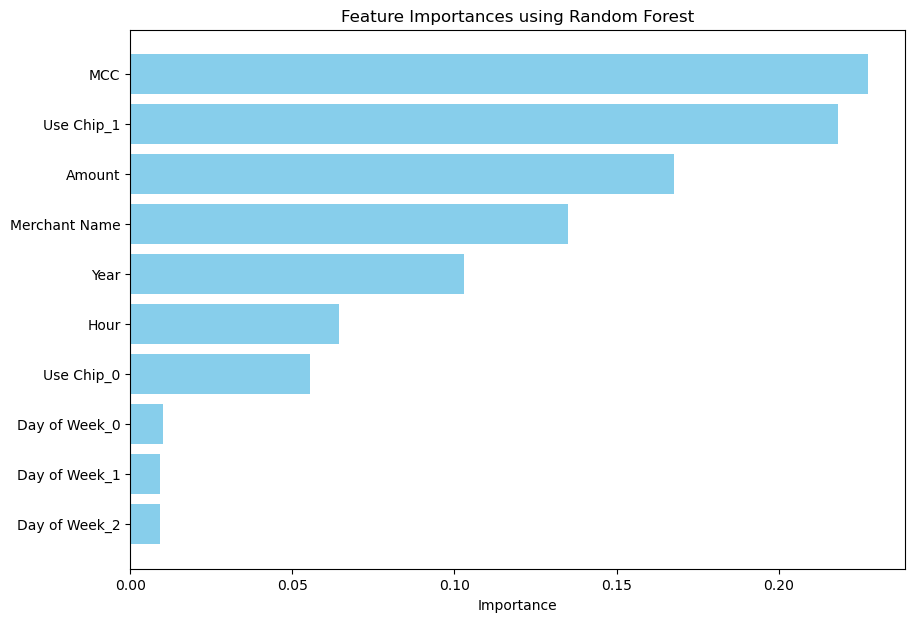

In [27]:
# Extract feature importances from the best random forest model
feature_importance = best_rf.feature_importances_
features = X_train.columns

# Sort the feature importances and their corresponding feature names
sorted_idx = feature_importance.argsort()

# Plot horizontal bar chart
plt.figure(figsize=(10, 7))
plt.barh(features[sorted_idx], feature_importance[sorted_idx], align='center', color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.show()

In [28]:
df_test = pd.read_csv('../data/processed/test.csv')

In [29]:
df_test = df_test[columns_to_select]

In [30]:
df_test = preprocessing_pipeline.transform(df_test)

In [32]:
X_test = df_test.drop(columns=['Is Fraud?'])
y_test = df_test['Is Fraud?']

In [33]:
df_test = None

In [34]:
test_prediction = best_rf.predict(X_test)

print("Random Forest Classifier Test Results:")
print(classification_report(y_test, test_prediction))
print(confusion_matrix(y_test, test_prediction))

Random Forest Classifier Test Results:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99   1721851
         1.0       0.03      0.52      0.06      2087

    accuracy                           0.98   1723938
   macro avg       0.52      0.75      0.52   1723938
weighted avg       1.00      0.98      0.99   1723938

[[1688946   32905]
 [   1006    1081]]


In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

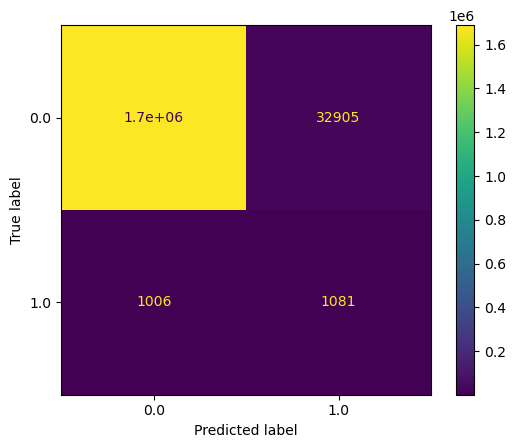

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_prediction),
                              display_labels=best_rf.classes_)
disp.plot()
plt.show()

In [37]:
amount_scaled = X_test['Amount'].values.reshape(-1, 1)
amount_rescaled = scaler.inverse_transform(amount_scaled)

In [38]:
X_test['Amount'] = scaler.inverse_transform(X_test['Amount'].values.reshape(-1, 1))

In [39]:
X_test['Prediction'] = test_prediction

In [40]:
X_test['Saved'] = X_test['Amount'] * X_test['Prediction']

In [41]:
X_test['Saved'].sum()

1763056.509999999

In [42]:
X_test['Amount'].sum()

73682938.67

In [43]:
saved_ratio = X_test['Saved'].sum() / X_test['Amount'].sum()
saved_ratio

0.023927608505085688

### Проверим на всей обучающей выборке лучшую модель без undersampling

In [50]:
X = df_transformed[(df_transformed['Year'] == 2017) | (df_transformed['Year'] == 2018)].drop(columns=['Is Fraud?'])
y = df_transformed[(df_transformed['Year'] == 2017) | (df_transformed['Year'] == 2018)]['Is Fraud?']

In [51]:
rf_classifier = RandomForestClassifier(**grid_search.best_params_)
rf_classifier.fit(X, y)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Prediction
- Saved


In [78]:
X_test = preprocessing_pipeline.transform(X_test)

In [82]:
X_test = X_test.drop(columns=['Prediction', 'Saved'])

In [83]:
y_test_preds = rf_classifier.predict(X_test)

print("Random Forest Classifier Results:")
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))

Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1721851
         1.0       0.49      0.13      0.20      2087

    accuracy                           1.00   1723938
   macro avg       0.74      0.56      0.60   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1721571     280]
 [   1818     269]]


In [84]:
X_test['Amount'] = scaler.inverse_transform(X_test['Amount'].values.reshape(-1, 1))

In [85]:
X_test['Prediction'] = y_test_preds

In [90]:
X_test['Is Fraud'] = y_test

In [91]:
X_test['Saved'] = (X_test['Amount'] * X_test['Prediction'])*X_test['Is Fraud']

In [92]:
X_test['Saved'].sum()

1700420.08425038

In [93]:
X_test['Amount'].sum()

5977516895.259272

In [89]:
X_test

,Year,Hour,Amount,Merchant Name,MCC,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2,Prediction,Saved
0,2019.0,0.0,9605.641176,-3.693651e+18,4814.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2019.0,0.0,1535.466902,-6.160036e+18,4121.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2019.0,0.0,8055.225447,-4.282467e+18,4829.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2019.0,0.0,2646.798486,-1.856939e+18,5192.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2019.0,0.0,8479.887120,4.722913e+18,5411.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1723933,2019.0,23.0,4850.231693,-4.282467e+18,4829.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1723934,2019.0,23.0,5517.671642,-2.451783e+17,5311.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1723935,2019.0,23.0,6274.050168,-5.162038e+18,5541.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1723936,2019.0,23.0,8498.315834,4.241336e+18,4814.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [75]:
saved_ratio = X_test['Saved'].sum() / X_test['Amount'].sum()
saved_ratio

0.0005481663672731174

In [76]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

2024/06/02 19:09:16 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/06/02 19:09:16 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [77]:
import mlflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("fraud_detection")

2024/06/02 19:10:09 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/lakeo/Projects/mlds_fraud/notebooks/mlruns/1', creation_time=1717344609531, experiment_id='1', last_update_time=1717344609531, lifecycle_stage='active', name='fraud_detection', tags={}>

In [94]:
with mlflow.start_run():
    mlflow.set_tag("iteration","baseline")

    mlflow.log_param("sampling", "No sampling")
    mlflow.log_param("model", "Random Forest")
    
    mlflow.log_metric("Precision", 0.49)
    mlflow.log_metric("Recall", 0.13)
    mlflow.log_metric("FP", 280)
    mlflow.log_metric("Saved money", 1700420)
    
    

In [95]:
with mlflow.start_run():
    mlflow.set_tag("iteration","baseline")

    mlflow.log_param("sampling", "Undersampling 1:5")
    mlflow.log_param("model", "Random Forest")
    
    mlflow.log_metric("Precision", 0.03)
    mlflow.log_metric("Recall", 0.52)
    mlflow.log_metric("FP", 32905)
    mlflow.log_metric("Saved money", 1963056)
    